In [0]:
%tensorflow_version 2.x
import tensorflow as tf

# layers - model - optimizeres
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

# additional imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

TensorFlow 2.x selected.


In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv")

In [0]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [0]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [0]:
# Start by doing the WRONG thing- trying to predict the price itself
# lets work with 1D time series by only using Close data
series = df['close'].values.reshape(-1,1)

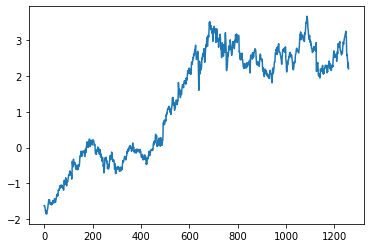

In [0]:
plt.plot(series) # we can see that the data is not the linear, so I'll pass the linear RNN

In [0]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
# Note we only called fit on the first half of the data
scaler.fit(series[:len(series) // 2])
# thats because I don't want to include test data in the training pipeline
# but we transform everything we see
# I selected the boundary as .5 of the data but it's probably different
# so we would do some extra calculation to find the boundary 
# but I believe 50% of the data is probably good enough. 
# NOTE: It may be good enough but it's off a little from real boundary 
series = scaler.transform(series).flatten() # I'm flattening the data to make it N length vector again

In [0]:
# the data is conceptually not different from sin wave
# It is no longer a sine wave but a real data from a real stock
# build the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, D) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [0]:
### try autogregressive RNN model
i = Input(shape = (T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer = Adam(lr=0.1)
)

# train the RNN
r = model.fit(X[:-N//2],
              Y[:-N//2],
              validation_data = (X[-N//2:], Y[-N//2:]),
              epochs = 80)



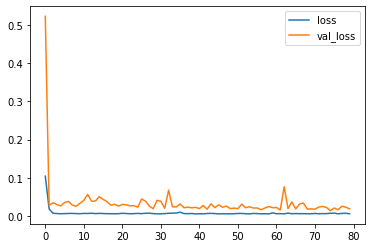

In [0]:
# Plot loss per iteration
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
# 

(1249, 1)


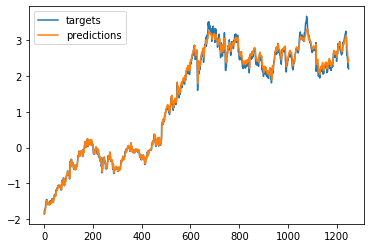

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
preds = outputs[:,0]
plt.plot(Y, label = 'targets')
plt.plot(preds, label = 'predictions')
plt.legend()
plt.show()

(10, 1)


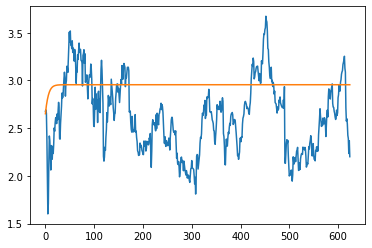

In [0]:
# multi-step forecast 
validation_target = Y[-N//2:]
validation_preds = []

# last train input
last_x = X[-N//2] # 1-D array of length T
print(last_x.shape)

while len(validation_preds) < len(validation_target):
  p = model.predict(last_x.reshape(-1, T, D))[0,0]

  # update the prediction list
  validation_preds.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_preds, label = 'forecast prediction')

If we compare the both results, one-step forecast looks better 
but actually its worse than multi-step forecast
because these results mean that the model isn't really predicting
next value in the time series, it's just copies the previous value.

Lesson #1: one-step prediction on stock prices is misleading and also unconventional

- What is more conventionally predicted is the stock return 

#### Stock return formula
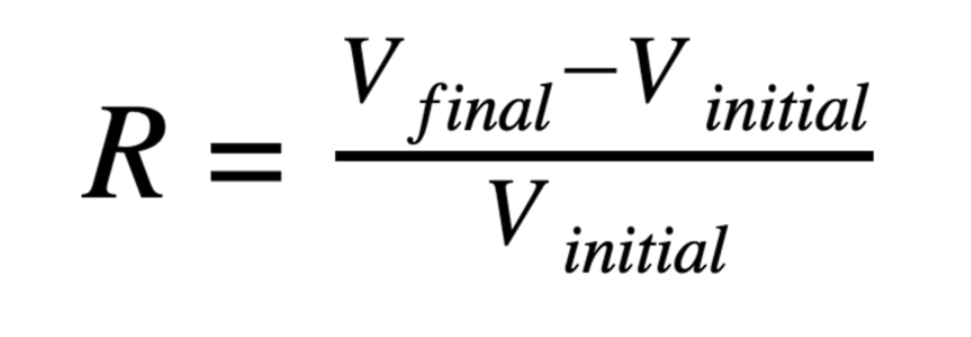

What does it mean for something to be 20% off? 
Intuitively, if something costs \$100 and is 20% off, you'll pay $80. So


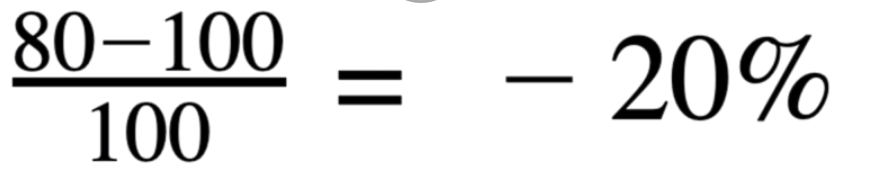

To summarize, when financial engineers do quote unquote stock prediction they are usually looking at some form of return, not actual prices

In [0]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1)
df.head()
# so now it's like 
# close / prev close
# x[2] x x[1]
# x[3] x x[2]
# ...
# x[t] x[t-1]

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [0]:
# Then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [0]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


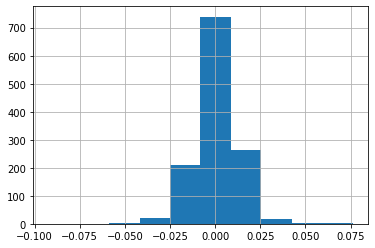

In [0]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [0]:
# taking everything from 1 is because 0th row doesn't have a return value
# it's undefined as NaN
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data since everything is so small
# Note: Again this is not the real boundary
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten() 
print(series.shape)

(1258,)


In [0]:
### build the dataset
T = 30
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t: t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

print('X.shape before reshaping:', np.array(X).shape)
X = np.array(X).reshape(-1, T, D) # Reshape it to NxTxD
Y = np.array(Y)
N = len(X)
print('Shapes after reshaping:')
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape before reshaping: (1228, 30)
Shapes after reshaping:
X.shape (1228, 30, 1) Y.shape (1228,)


In [0]:
### try autogregressive RNN model
i = Input(shape = (T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer = Adam(lr=0.1)
)

# train the RNN
r = model.fit(X[:-N//2],
              Y[:-N//2],
              validation_data = (X[-N//2:], Y[-N//2:]),
              epochs = 80)

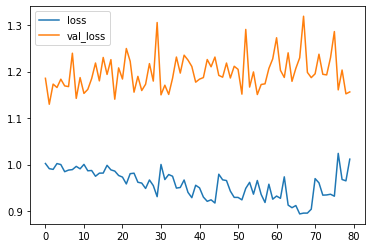

In [0]:
# Plot loss per iteration
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

(1248, 1)


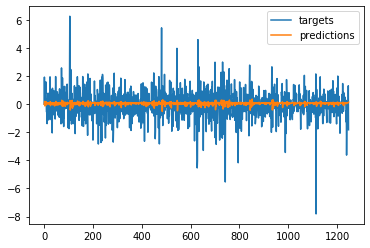

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label = 'targets')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.show()

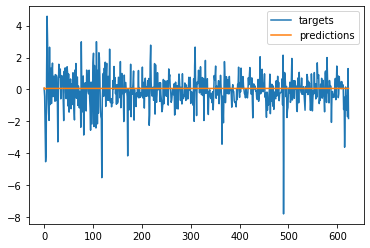

In [0]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(-1,T,D))[0,0]

  # update the prediction list
  validation_predictions.append(p)

  # make the next input value
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label = 'targets')
plt.plot(validation_predictions, label = 'predictions')
plt.legend()
plt.show()

We have the situation where the model isn't really able to do much 
except copy the same value over and over again.

The first example was an example for wrong approach,
Also there isn't really anything wrong with the second model, it just wasn't a good model

Now let's make use of all the data: open, high, low, close, volume (D=5)
And from this, let's do the simplest task possible: predict whether the price will go up or down (equivalent to predicting whether the return is +ve or -ve). In other words, binary classification!

Regression is in general more difficult problem than classification, because you're trying to predict continuous value. When it comes to stock returns, we should use this approach hence its the simplest one


In [0]:
# Now turn the full data into numpy arrays

# Not yet in the final 'X' format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [0]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a preidction for the next day
D = input_data.shape[1] # 5
N = len(input_data) - T # (e.g. if T = 10 and you have 11 data points then you'd only have 1 sample)

In [0]:
# Normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [0]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [0]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N- Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  # t allows us to loop through input_data[Ntrain:]
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T]>0)

In [0]:
# Make the RNN
i = Input(shape = (T,D))
x = LSTM(50)(i)
x = Dense(1, activation = 'sigmoid')(x) # binary classification
model = Model(i, x)
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'],)

In [0]:
# train the RNN
r = model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs = 300,
    validation_data = (X_test, Y_test),
    )


Train on 839 samples, validate on 410 samples
Epoch 1/300
839/839 [==============================] - 2s 2ms/sample - loss: 0.7006 - accuracy: 0.4744 - val_loss: 0.6931 - val_accuracy: 0.5122
Epoch 2/300
839/839 [==============================] - 0s 261us/sample - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6943 - val_accuracy: 0.4829
Epoch 3/300
839/839 [==============================] - 0s 262us/sample - loss: 0.6918 - accuracy: 0.5256 - val_loss: 0.6938 - val_accuracy: 0.4878
Epoch 4/300
839/839 [==============================] - 0s 258us/sample - loss: 0.6915 - accuracy: 0.5268 - val_loss: 0.6930 - val_accuracy: 0.4829
Epoch 5/300
839/839 [==============================] - 0s 257us/sample - loss: 0.6906 - accuracy: 0.5316 - val_loss: 0.6953 - val_accuracy: 0.4927
Epoch 6/300
839/839 [==============================] - 0s 250us/sample - loss: 0.6901 - accuracy: 0.5316 - val_loss: 0.6917 - val_accuracy: 0.4976
Epoch 7/300
839/839 [==============================] - 0s 268us/sample - l

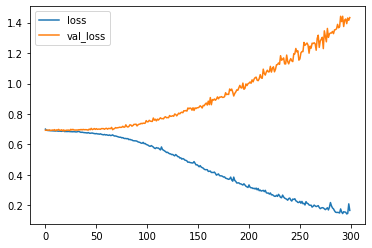

In [0]:
# plot the loss
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

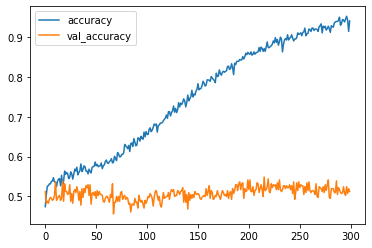

In [0]:
# plot the accuracy
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

We can say that the model is just again over fitting to the noise
in the train set 
from seeing that the train loss goes down a little bit but the
validation loss goes up a lot.


So that's what it means when train loss goes down but validation loss goes up
If we can look at the accuracy, we can see same thing. 


One important lesson in binary classification is 
0% accuracy is not worst accuracy. If your accuracy is %0
you can just reverse the model and make the predictions
%100 which means the perfect model. 
The worst accuracy is ~50% because predictions are not better than
random guessing, that's why the test accuracy remains 50% as the model overfits

## Summary
We went through 3 examples
* 1) Predict future stock prices from past stock prices with LSTM
    * *Only appears to work well with one step forecast*
    * It didn't work so well for multi-step forecasts
* 2) Predict future stock returns
* 3) Use all 5 columns for binary classification(up/down)
* Even for the *simplest* task with the *most* data, the model still doesn't do better than random guessing, 
* Lesson: There wasn't any hope of #1 and #2 succeeding in the first place
* If we can't even predict whether the stock will go up or down, how can we predict the actual return *value* or the *price*?
* Be suspicious whenever you see an almost-perfect stock price forecast 
* This should not be surprising considering the previous examples
* We couldn't even predict a noisy sine wave
* A sine wave is deterministic! It should be easy!
## A fundamental flaw
* What about real-world events?
* Why does a stock price go up or down?
* Usually, it's due to some occurrence in the real world!
* Isn't it ludicrous to assume that the future is deterministic given historical stock prices?
* More realistically, a stock depends on emotions of investors - how the company is portrayed in the media, new inventions, etc.
* Ex. Facebook being investigated by the government -> stock goes down
## Predicting the future
* Using historical stock prices alone is like saying these are what influence future events like Elon Musk making a stupid tweet
* World events are not preordained by stock prices!
* If you really want to study stock prediction, that could be a lifetime of study - if you can really do it, then you are probably well-equipped to start your own company
* This isn't to say LSTMs aren't good - they have proved themselves time and time again 